# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import numpy as np
import cv2
import open3d as o3d
import os
import matplotlib.pyplot as plt
import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# camera calibration
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], 
              [0.000000e+00, 7.070912e+02, 1.831104e+02], 
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])

f = K[0][0]
baseline = 0.53790448812

# get pose information for each image pair
transforms = []
with open("../data/poses.txt") as file:
    for line in file:
        values = line.split()
        transforms.append(np.array(values, dtype=np.float32).reshape((3, 4)))

In [3]:
def generateDisparityMap(img_left, img_right):
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    # generate disparity map
    window_size = 5
    min_disparity = 16
    num_disparity = 128
    stereo = cv2.StereoSGBM_create(
        blockSize         = 7,
        minDisparity      = min_disparity,
        numDisparities    = num_disparity,
        preFilterCap      = 0,
        uniquenessRatio   = 10,
        speckleWindowSize = 400,
        speckleRange      = 10,
        disp12MaxDiff     = 1,
        P1                = 8 * 3 * window_size**2, 
        P2                = 32 * 3 * window_size**2,
    )
    disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
    return disparity

In [4]:
# plot images and disparity map
def showDisparity(img_left, img_right, disparity):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
    ax3.imshow(disparity, "gray")
    plt.show()

In [5]:
# calculate Q matrix
def calculateQ(h, w):
    return np.array([[1,  0,          0, -w/2],
                     [0, -1,          0,  h/2], 
                     [0,  0,          0,   -f], 
                     [0,  0, 1/baseline,    0]])

In [6]:
def generatePointCloud():
    point_clouds = []
    
    # loop over all image pairs
    for i in range(21):
        file1 = f"../data/img2/0000000{460 + i}.png"
        file2 = f"../data/img3/0000000{460 + i}.png"
        
        img_left = cv2.imread(file1)
        img_right = cv2.imread(file2)
        
        # calculate disparity
        print("Image pair: ", i)
        disparity = generateDisparityMap(img_left, img_right)
        showDisparity(img_left, img_right, disparity)
        
        # calculate Q matrix
        Q = calculateQ(*img_left.shape[:2])
        
        # reproject to 3D
        points = cv2.reprojectImageTo3D(disparity, Q)
        colors = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB) / 255
        
        # choose points with disparity above zero
        mask = disparity >= 0
        points = points[mask]
        colors = colors[mask]
                
        # transform points into world frame
        R = transforms[i][:, :-1]
        t = transforms[i][:, -1].reshape(-1, 1)
        points = (R @ points.T + t).T
        
        # convert to 3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        point_clouds.append(pcd)
    
    return point_clouds

Image pair:  0


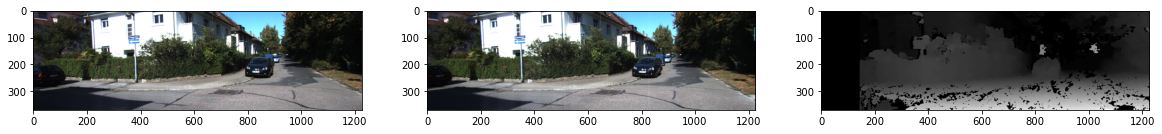

Image pair:  1


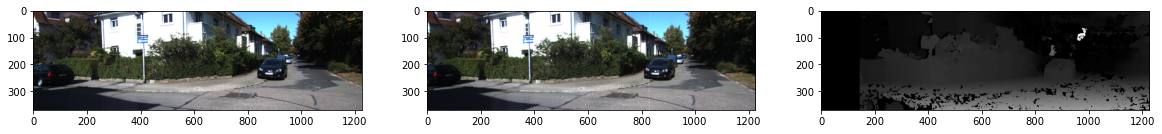

Image pair:  2


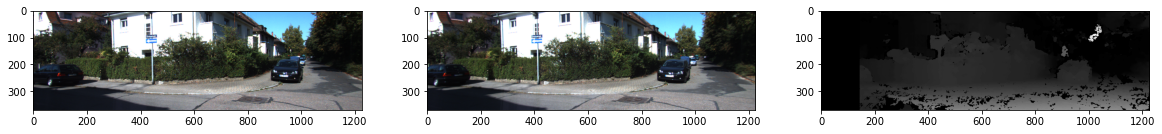

Image pair:  3


Image pair:  4


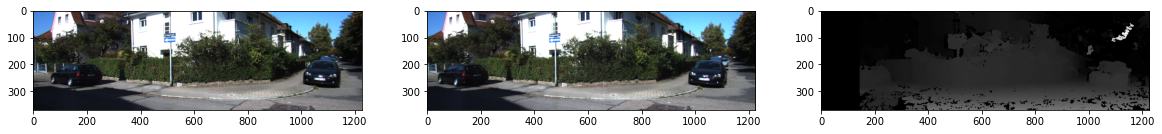

Image pair:  5


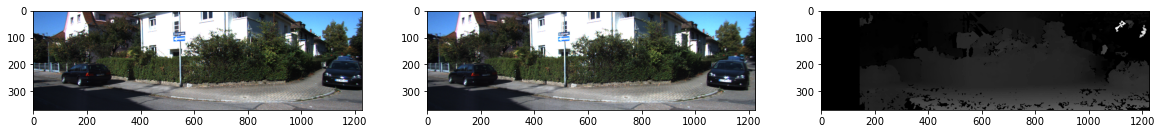

Image pair:  6


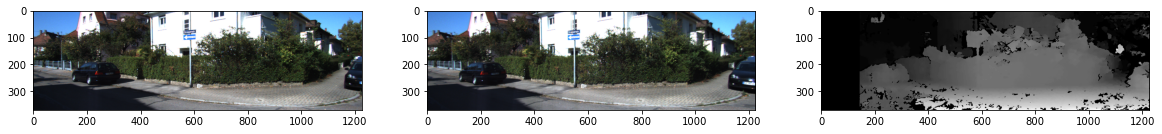

Image pair:  7


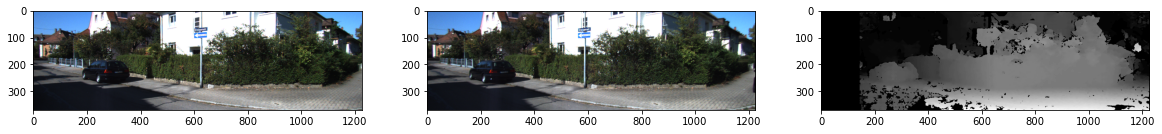

Image pair:  8


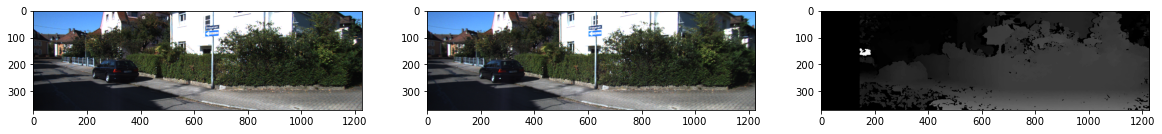

Image pair:  9


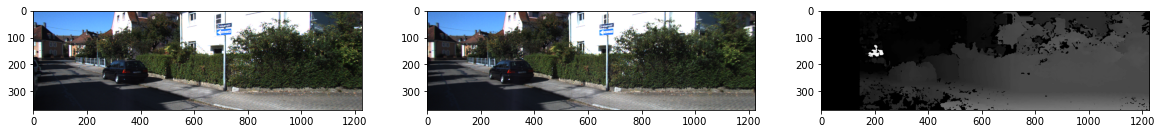

Image pair:  10


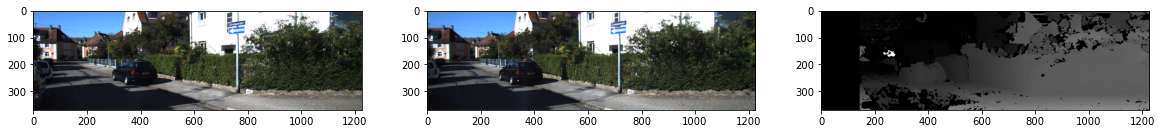

Image pair:  11


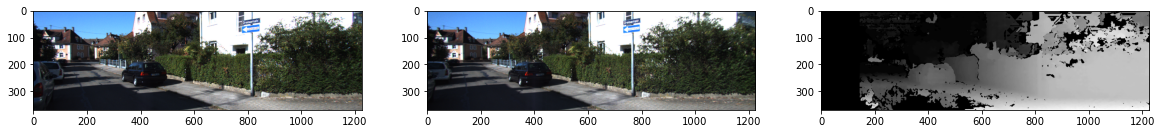

Image pair:  12


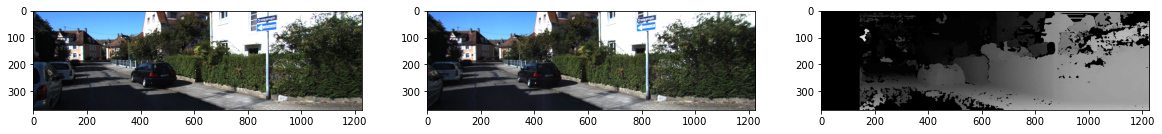

Image pair:  13


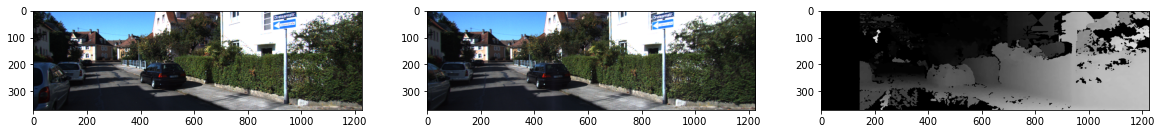

Image pair:  14


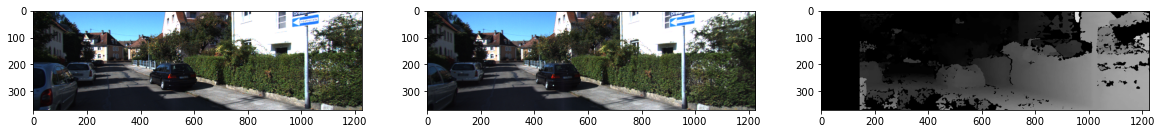

Image pair:  15


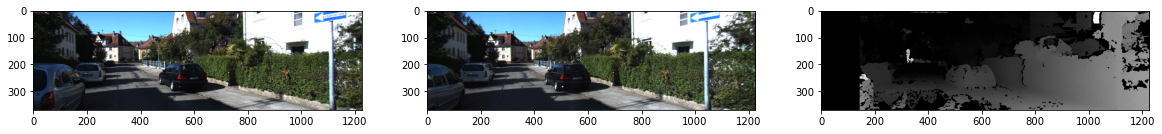

Image pair:  16


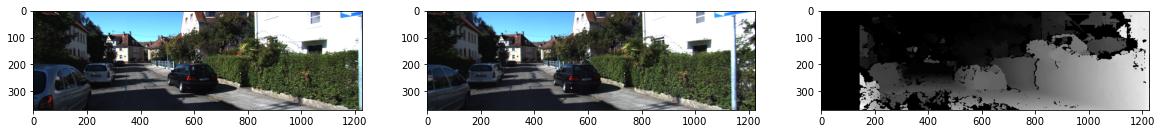

Image pair:  17


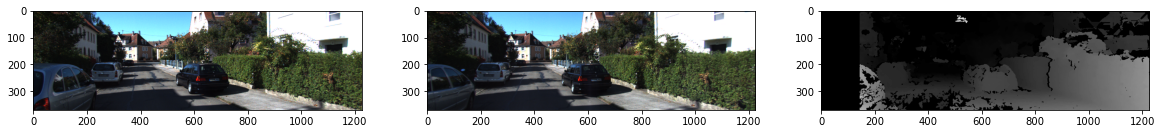

Image pair:  18


Image pair:  19


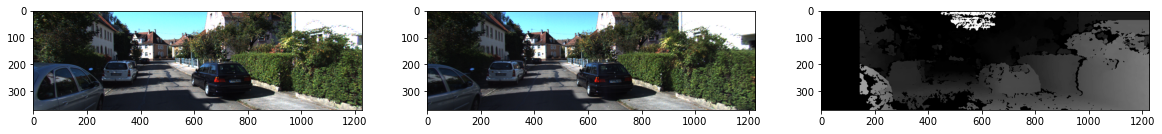

Image pair:  20


In [7]:
point_clouds = generatePointCloud()

In [8]:
# visualize individual point clouds
o3d.visualization.draw_geometries([point_clouds[0]])
o3d.visualization.draw_geometries([point_clouds[7]])
o3d.visualization.draw_geometries([point_clouds[15]])

In [9]:
# visualize combined point cloud
combined_pcd = o3d.geometry.PointCloud()
for pcd in point_clouds:
    combined_pcd += pcd
    
o3d.visualization.draw_geometries([combined_pcd])

### Disparity map using StereoSGBM

- Semi-Global Block Matching (SGBM) is an algorithm used to estimate a dense disparity map from a pair of rectified stereo images.
- To calculate the disparity map, we need to relate a pixel in the 1st image to a pixel in the same row in the 2nd image. However, this may not give good results, especially when there is a lack of texture in the images.
- Instead, we relate blocks around pixels in the left and right images, using a method like Sum of Absolute Differences (SAD). This is known as Block Matching (BM). The disparity with the least cost is taken is chosen for each pixel individually.
- In addition to calculating the disparities for each pixel spearately, SGBM enforces the smoothing constraint that neighbouring pixels or blocks should have similar disparities. Hence, it uses global information to compute the disparities of pixels. This results in a smoothing effect and gives better results globally.

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

In [10]:
# get ground truth P
pcd_idx = 5
T = np.vstack((transforms[pcd_idx], [0, 0, 0, 1]))
T = np.linalg.inv(T)[:-1, :]

P_gt = K @ T
print(P_gt)

[[-8.03452184e+02  3.76050750e+01 -4.64000785e+02 -1.26896049e+05]
 [-1.00269786e+01  7.12050189e+02 -1.62454310e+02  5.17423816e+03]
 [-1.79889936e-01  3.03045449e-02 -9.83219876e-01  1.70718882e+01]]


In [11]:
# obtain 3D-2D correspondences
def findCorrespondences(points, P, num_points=500):
    points_2d = []
    points_3d = []
    
    # homogenize 3d points
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    
    # choose random points
    for i in random.sample(range(0, points.shape[0]), num_points):
        point_2d = P @ points[i]
        
        points_2d.append(point_2d)
        points_3d.append(points[i])  
        
    return np.array(points_2d), np.array(points_3d)

In [12]:
points = np.asarray(combined_pcd.points)
points_2d, points_3d = findCorrespondences(points, P_gt)
print(points_2d.shape, points_3d.shape)

(500, 3) (500, 4)


### Calculation of Residual and Jacobian

The reprojection error is given by $\sum_{i} ‖x_i−P_{k}X_i‖^2 $.  
This is a least squares optimization problem.  
We minimize the sum of squares of $ (x_i$ - $PX_i) $ over all 2D-3D correspondences.  

**For a single correspondence, we have:**
$$
\begin{align}
x_i−P_{k}X_i &= \begin{bmatrix}
x_i \\
y_i \\
z_i
\end{bmatrix} - \begin{bmatrix}
P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & P_{24} \\
P_{31} & P_{32} & P_{33} & P_{34} \\
\end{bmatrix} \begin{bmatrix}
X_i \\ 
Y_i \\
Z_i \\
1
\end{bmatrix} \\
&= \begin{bmatrix}
x_i - P_{11}X_i + P_{12}Y_i + P_{13}Z_i + P_{14} \\
y_i - P_{21}X_i + P_{22}Y_i + P_{23}Z_i + P_{24} \\
z_i - P_{31}X_i + P_{32}Y_i + P_{33}X_i + P_{34} \\
\end{bmatrix}
\end{align}
$$

And,
$$
r = ||x_i−P_{k}X_i||^2
$$

Now, for each point, we differentiate with respect to all parameters of P.  
We take P to be a $ 12 \times 1 $ vector.  

For $ P_{1} $: 
$$ \frac{dr}{dP_1} = (x_i - (P_{1}X_i + P_{2}Y_i + P_{3}Z_i + P_{4})) \times (-X_i) $$

For $ P_{2} $: 
$$ \frac{dr}{dP_2} = (x_i - (P_{1}X_i + P_{2}Y_i + P_{3}Z_i + P_{4})) \times (-Y_i) $$

For $ P_{3} $: 
$$ \frac{dr}{dP_3} = (x_i - (P_{1}X_i + P_{2}Y_i + P_{3}Z_i + P_{4})) \times (-Z_i) $$

For $ P_{4} $: 
$$ \frac{dr}{dP_4} = (x_i - (P_{1}X_i + P_{2}Y_i + P_{3}Z_i + P_{4})) $$

And similarly for other parameters.

So,
$$
J = \begin{bmatrix}
\frac{dr}{dP_1}
\frac{dr}{dP_2}
...
\frac{dr}{dP_{12}}
\end{bmatrix}
$$

**We now stack up these results for all correspondences.**

If the number of correspondences is $n$,  

$$
r_{n \times 1} = \begin{bmatrix}
r_1 \\
r_2 \\
.. \\
.. \\
r_n
\end{bmatrix} \text{ and }
J_{n \times 12} = \begin{bmatrix}
J_1 \\
J_2 \\
.. \\
.. \\
J_n
\end{bmatrix}
$$

In [13]:
def findResidual(points_2d, points_3d, P):
    P = P.reshape((3, 4))
    residual = []
    
    for i in range(points_2d.shape[0]):
        norm = (points_2d[i] - P @ points_3d[i]) ** 2
        residual.append(np.sum(norm))
        
    return np.array(residual).reshape(-1, 1)

In [14]:
def findError(points_2d, points_3d, P):
    res = findResidual(points_2d, points_3d, P)
    return np.sum(res)

In [15]:
def findJacobian(points_2d, points_3d, P):
    J = np.zeros((points_2d.shape[0], 12))
    
    for i in range(points_2d.shape[0]):
        x, y, z = points_2d[i]
        X, Y, Z, W = points_3d[i]
        
        # differentiate wrt 1st row of P
        J[i][0]  = 2 * (x - (P[0] * X + P[1] * Y + P[2] * Z  + P[3] * W)) * (-X)
        J[i][1]  = 2 * (x - (P[0] * X + P[1] * Y + P[2] * Z  + P[3] * W)) * (-Y)
        J[i][2]  = 2 * (x - (P[0] * X + P[1] * Y + P[2] * Z  + P[3] * W)) * (-Z)
        J[i][3]  = 2 * (x - (P[0] * X + P[1] * Y + P[2] * Z  + P[3] * W)) * (-W)
        
        # differentiate wrt 2nd row of P
        J[i][4]  = 2 * (y - (P[4] * X + P[5] * Y + P[6] * Z  + P[7] * W)) * (-X)
        J[i][5]  = 2 * (y - (P[4] * X + P[5] * Y + P[6] * Z  + P[7] * W)) * (-Y)
        J[i][6]  = 2 * (y - (P[4] * X + P[5] * Y + P[6] * Z  + P[7] * W)) * (-Z)
        J[i][7]  = 2 * (y - (P[4] * X + P[5] * Y + P[6] * Z  + P[7] * W)) * (-W)
        
        # differentiate wrt 3rd row of P
        J[i][8]  = 2 * (z - (P[8] * X + P[9] * Y + P[10] * Z + P[11] * W))* (-X)
        J[i][9]  = 2 * (z - (P[8] * X + P[9] * Y + P[10] * Z + P[11] * W))* (-Y)
        J[i][10] = 2 * (z - (P[8] * X + P[9] * Y + P[10] * Z + P[11] * W))* (-Z)
        J[i][11] = 2 * (z - (P[8] * X + P[9] * Y + P[10] * Z + P[11] * W))* (-W)
        
    return J

In [16]:
def gaussNewton(points_2d, points_3d, P, max_iter=50, tolerance=1e-5):
    errors = []
    prev_error = findError(points_2d, points_3d, P)
    errors.append(prev_error)
    
    for i in range(1, max_iter + 1):
        # caluclate f(x) and J(x)
        J = findJacobian(points_2d, points_3d, P)
        f = findResidual(points_2d, points_3d, P)
        
        # calculate delta X
        del_P = np.linalg.pinv(J.T @ J) @ -J.T @ f
        
        # update step
        P += del_P
        
        # find error
        error = findError(points_2d, points_3d, P)
        errors.append(error)
        
        if abs(prev_error - error) < tolerance:
            print("Tolerance reached")
            break
        
        prev_error = error
        print(f"Error after iteration {i}: {error}")
        
    return P.reshape((3, 4)), errors

In [17]:
def plot(title, errors):
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel("Number of iterations")
    plt.ylabel("Error")
    plt.xticks([i for i in range(0, len(errors), 1)])
    plt.plot(errors)

### Estimate 1: Initializing P with zeros

Error after iteration 1: 21246655188.91107
Error after iteration 2: 5311663797.223919
Error after iteration 3: 1327915949.3059492
Error after iteration 4: 331978987.3264029
Error after iteration 5: 82994746.8315311
Error after iteration 6: 20748686.707885195
Error after iteration 7: 5187171.67697152
Error after iteration 8: 1296792.9192427387
Error after iteration 9: 324198.22981023276
Error after iteration 10: 81049.55745244632
Error after iteration 11: 20262.389363088936
Error after iteration 12: 5065.597340797025
Error after iteration 13: 1266.3993352035968
Error after iteration 14: 316.59983380073027
Error after iteration 15: 79.14995845033012
Error after iteration 16: 19.787489611215392
Error after iteration 17: 4.9468724030314375
Error after iteration 18: 1.2367181005892338
Error after iteration 19: 0.30917952512530983
Error after iteration 20: 0.07729488120950437
Error after iteration 21: 0.019323720339740794
Error after iteration 22: 0.004830930100089994
Error after iteration 2

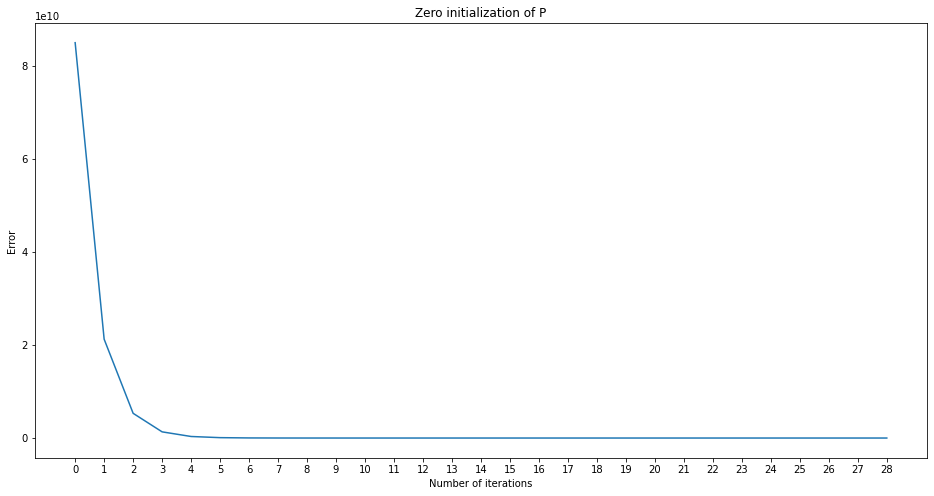

In [18]:
# initialize P with zeros
P = np.zeros((12, 1))
P, errors = gaussNewton(points_2d, points_3d, P)
plot("Zero initialization of P", errors)

### Estimate 2: Random Initialization

Error after iteration 1: 21118807456.487476
Error after iteration 2: 5279701864.11885
Error after iteration 3: 1319925466.0293298
Error after iteration 4: 329981366.5074265
Error after iteration 5: 82495341.62683243
Error after iteration 6: 20623835.406712435
Error after iteration 7: 5155958.851677277
Error after iteration 8: 1288989.7129200567
Error after iteration 9: 322247.428230037
Error after iteration 10: 80561.85705746475
Error after iteration 11: 20140.464264373302
Error after iteration 12: 5035.116066088922
Error after iteration 13: 1258.7790165227098
Error after iteration 14: 314.69475413495024
Error after iteration 15: 78.67368853425623
Error after iteration 16: 19.66842213245816
Error after iteration 17: 4.917105532805652
Error after iteration 18: 1.229276382832325
Error after iteration 19: 0.3073190955641403
Error after iteration 20: 0.07682977383536818
Error after iteration 21: 0.01920744346274835
Error after iteration 22: 0.0048018608688635885
Error after iteration 23: 0

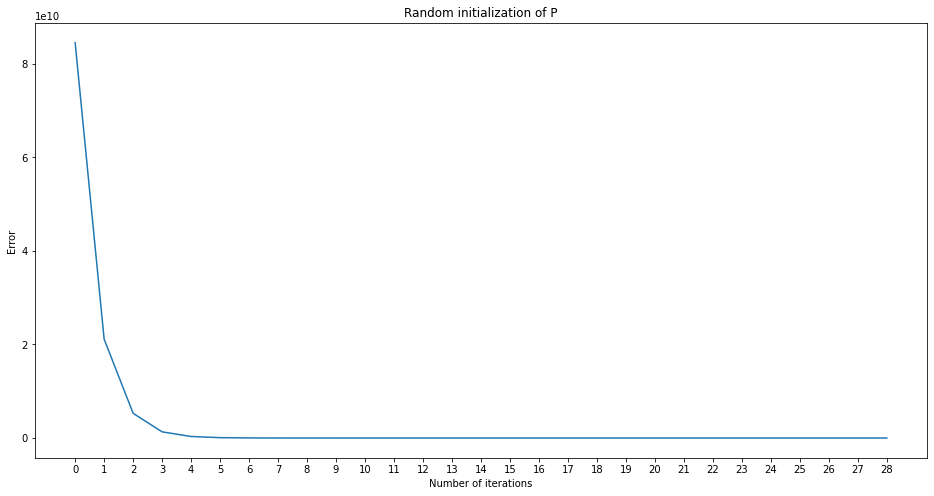

In [19]:
# initialize P with random noise
P = np.random.rand(12, 1)
P, errors = gaussNewton(points_2d, points_3d, P)
plot("Random initialization of P", errors)

### Estimate 3: Initializing P with DLT output

In [20]:
def DLT(x, X):
    A = []
    
    for (xi, yi), (Xi, Yi, Zi) in zip(x, X):
        A.append([Xi, Yi, Zi, 1, 0, 0, 0, 0, -Xi * xi, -Yi * xi, -Zi * xi, -xi])
        A.append([0, 0, 0, 0, Xi, Yi, Zi, 1, -Xi * yi, -Yi * yi, -Zi * yi, -yi])
    
    A = np.array(A)
    U, D, VT = np.linalg.svd(A)
    P = VT[-1, :].reshape(3, 4)
    P /= P[-1, -1]
    return P

In [21]:
# initialize P using DLT
P = DLT(points_2d[:, :-1], points_3d[:, :-1])
P = P.reshape((12, 1))
P, errors = gaussNewton(points_2d, points_3d, P)
plot("P initialized using DLT", errors)

Error after iteration 1: 36827.21341622579
Error after iteration 2: 9206.803589321058
Error after iteration 3: 2301.731037554283
Error after iteration 4: 575.4327601665805
Error after iteration 5: 143.8581903538918
Error after iteration 6: 35.9645475645097
Error after iteration 7: 8.99113690052744
Error after iteration 8: 2.247784222874758
Error after iteration 9: 0.5619460555530322
Error after iteration 10: 0.1404865141008358
Error after iteration 11: 0.03512162856234892
Error after iteration 12: 0.008780407158519892
Error after iteration 13: 0.002195101794504663
Error after iteration 14: 0.0005487754483438092
Error after iteration 15: 0.00013719387303104996
Error after iteration 16: 3.429847027707838e-05
Error after iteration 17: 8.57462006443793e-06
Tolerance reached


#### Observations

- Zero initialization converged in 27 iterations.
- Random initialization converged in 27 iterations.
- Initializing with DLT output converged in 17 iterations. Using DLT as an initial estimate hence results in faster convergence.
- In all cases, we were able to recover the pose of the camera using iterative PnP from known 2D-3D correspondences.

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

### 3.1

In [22]:
def getCorrs(img1, img2):
    sift = cv2.SIFT_create()
    keypts1, desc1 = sift.detectAndCompute(img1, None)
    keypts2, desc2 = sift.detectAndCompute(img2, None)

    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv2.drawMatches(img1, keypts1, img2, keypts2, matches[:50], img2, flags=2)
    plt.figure(figsize=[20, 20])
    plt.imshow(img3)
    plt.show()
    
    corr1 = []
    corr2 = []
    for match in matches:
        corr1.append(np.array(keypts1[match.queryIdx].pt))
        corr2.append(np.array(keypts2[match.trainIdx].pt))
        
    corr1 = np.array(corr1).astype(int)
    corr2 = np.array(corr2).astype(int)
    return [corr1, corr2]

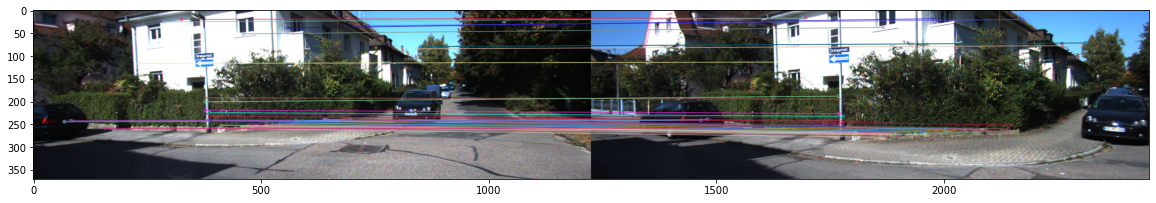

In [23]:
path1 = "../data/img2/0000000460.png"
path1_2 = "../data/img3/0000000460.png"
path2 = "../data/img2/0000000465.png"
path2_2 = "../data/img3/0000000465.png"

img1 = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
img1_2 = cv2.cvtColor(cv2.imread(path1_2), cv2.COLOR_BGR2RGB)

img2 = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)
img2_2 = cv2.cvtColor(cv2.imread(path2_2), cv2.COLOR_BGR2RGB)
[corr1, corr2] = getCorrs(img1, img2)

### 3.2

In [24]:
def get3D(corr, img1, img2):
    disparity = generateDisparityMap(img1, img2)
    Q = calculateQ(*img1.shape[:2])    
    # reproject to 3D
    points = cv2.reprojectImageTo3D(disparity, Q)
    pts3D = points[corr[:, 1], corr[:, 0], :]
    return pts3D

In [25]:
pts1 = get3D(corr1, img1, img1_2)
pts2 = get3D(corr2, img2, img2_2)

### 3.3

In [26]:
def findTransformationMatrix(R, t):
    t = t.reshape((-1, 1))
    return np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))

def findRotationAndTranslation(T):
    dim = T.shape[0] - 1
    R = T[:dim, :dim]
    t = T[:dim, dim]
    return R, t.reshape((-1, 1))

In [27]:
# orthogonal procrustes (transforms pc2 to pc1)
# pc1 and pc2 are of dimension 3 x n
def orthogonalProcrustes(pc1, pc2):
    # dimension of each point, number of points
    dim, n = pc1.shape

    # find centroids
    mu1 = np.mean(pc1, axis=1, keepdims=True)
    mu2 = np.mean(pc2, axis=1, keepdims=True)
    
    # center point clouds
    centered_pc1 = pc1 - mu1
    centered_pc2 = pc2 - mu2
    
    # solve using SVD
    W = centered_pc1 @ centered_pc2.T
    U, S, Vt = np.linalg.svd(W)
    
    # find R and t
    R = U @ Vt
    t = mu1 - R @ mu2
    
    # get transformation matrix from R and t
    T = findTransformationMatrix(R, t)
    
    # return matrices
    return T, R, t

In [28]:
# finds distance between pc1 and pc2
# pc1 and pc2 are of dimension 3 x n
def findPtError(pc1, pc2):
    return np.mean(np.linalg.norm(pc1 - pc2, axis=0))

In [29]:
T, R, t = orthogonalProcrustes(pts1.T, pts2.T)
T = T[:3, :]

with np.printoptions(precision=3, suppress=True):
    print("Calculated Transform Matrix: \n", T)

# find absolute error
error = findPtError(pts1.T, R @ pts2.T + t)
print("Error = ", error)

Calculated Transform Matrix: 
 [[ 1.    -0.006  0.004 -2.72 ]
 [ 0.006  0.998 -0.055 -0.664]
 [-0.003  0.055  0.998 -1.731]]
Error =  5.6268797


### 3.4

In [30]:
def findResidual(pts1, pts2, T):
    T = T.reshape((3, 4))
    residual = []
    
    for i in range(pts1.shape[0]):
        norm = (pts2[i, :-1] - (T @ pts1[i])) ** 2
        residual.append(np.sum(norm))
        
    return np.array(residual).reshape(-1, 1)

In [31]:
def findError(pts1, pts2, T):
    res = findResidual(pts1, pts2, T)
    return np.sum(res)

In [32]:
def findJacobian(pts1, pts2, T):
    J = np.zeros((pts1.shape[0], 12))
    
    for i in range(pts1.shape[0]):
        x, y, z, w = pts2[i]
        X, Y, Z, W = pts1[i]
        
        # differentiate wrt 1st row of P
        J[i][0]  = 2 * (x - (T[0] * X + T[1] * Y + T[2] * Z  + T[3] * W)) * (-X)
        J[i][1]  = 2 * (x - (T[0] * X + T[1] * Y + T[2] * Z  + T[3] * W)) * (-Y)
        J[i][2]  = 2 * (x - (T[0] * X + T[1] * Y + T[2] * Z  + T[3] * W)) * (-Z)
        J[i][3]  = 2 * (x - (T[0] * X + T[1] * Y + T[2] * Z  + T[3] * W)) * (-W)
        
        # differentiate wrt 2nd row of P
        J[i][4]  = 2 * (y - (T[4] * X + T[5] * Y + T[6] * Z  + T[7] * W)) * (-X)
        J[i][5]  = 2 * (y - (T[4] * X + T[5] * Y + T[6] * Z  + T[7] * W)) * (-Y)
        J[i][6]  = 2 * (y - (T[4] * X + T[5] * Y + T[6] * Z  + T[7] * W)) * (-Z)
        J[i][7]  = 2 * (y - (T[4] * X + T[5] * Y + T[6] * Z  + T[7] * W)) * (-W)
        
        # differentiate wrt 3rd row of P
        J[i][8]  = 2 * (z - (T[8] * X + T[9] * Y + T[10] * Z + T[11] * W))* (-X)
        J[i][9]  = 2 * (z - (T[8] * X + T[9] * Y + T[10] * Z + T[11] * W))* (-Y)
        J[i][10] = 2 * (z - (T[8] * X + T[9] * Y + T[10] * Z + T[11] * W))* (-Z)
        J[i][11] = 2 * (z - (T[8] * X + T[9] * Y + T[10] * Z + T[11] * W))* (-W)
        
    return J

In [33]:
homoPts1 = np.hstack([pts1, np.ones((pts1.shape[0], 1))])
homoPts2 = np.hstack([pts2, np.ones((pts2.shape[0], 1))])
optT, errors = gaussNewton(homoPts1, homoPts2, T.reshape((12, 1)))
plot("T initialized using ICP", errors)

Error after iteration 1: 267077.2903643337
Error after iteration 2: 160211.49230940806
Error after iteration 3: 204675.7337508318
Error after iteration 4: 365481.31663997064
Error after iteration 5: 212096.93499013636
Error after iteration 6: 154346.06590391608
Error after iteration 7: 307864.7731685545
Error after iteration 8: 192777.78772377147
Error after iteration 9: 301176.22070361825
Error after iteration 10: 250426.31443095184
Error after iteration 11: 202386.29139543197
Error after iteration 12: 280712.19504859776
Error after iteration 13: 210946.91975644554
Error after iteration 14: 188347.1299639404
Error after iteration 15: 299649.1909883877
Error after iteration 16: 207612.49793976077
Error after iteration 17: 206836.29418429825
Error after iteration 18: 211867.09093859533
Error after iteration 19: 222810.9299990452
Error after iteration 20: 226176.5450072835
Error after iteration 21: 202952.58802334004
Error after iteration 22: 241426.66896818695
Error after iteration 23: 